# Embedding
We start by developing an embedding of a dictionary. Since all potential words and misspellings that are in tweets would create an extremely large, but sparse vector, this would not be an efficient way of storing data.

The most common solution is to represent each word in the vocabulary using a fairly small and dense vector called an *embedding*, and just let the neural network learn a good embedding for each word during training. At the beginning of training, embeddings are simply chosen randomly, but during training, backpropagation automatically moves the embeddings around in a way that helps the neural network perform its task. This means that similar words will gradually cluster close to one another, and even end up organized in a rather meaningful way. Embeddings may end up placed along various axes that represent gender, singular/plural, adjective/noun, etc.

We first need to create the variable representing the embedding, then if we feed a sentence to the neural network, we first preprocess the sentence and break it into a list of known words. We may remove unnecessary characters, replace unknown words by a predefined token word such as "[UNK]", replace numerical values by "[NUM]", replace URLs with "[URL]", and so on. Once we have a list of known words, we can look up each word's integer identifier in a dictionary. At that point we are ready to feed these word identifiers to TensorFlow using a placeholder, and apply the `embedding_lookup()` function to get the corresponding embeddings.

Once our model has learned good word embeddings, they can actually be reused fairly efficiently in any NLP application. In fact, instead of training our own word embeddings, we may want to download pretrained word embeddings (like using pretrained layers, we can choose to freeze the pretrained embeddings by creating an `embeddings` variable using `trainable = False`, or let backpropagation tweak them for our application. The first option will speed up training, but the second may lead to slightly higher performance.

We form the dictionary from tweets scraped by keyword (list of 50 terms in `data-cleaner.ipynb`), and data collected from `twitter_samples` of the Natural Language Toolkit (`nltk`) database.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import glob
import string
import matplotlib.pyplot as plt
import matplotlib as mpl

nltk.download('punkt')

#import errno
#import os
#import zipfile

def reset_graph(seed = 42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\debro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# NLTK tweets
from nltk.corpus import twitter_samples

In [3]:
twitter_samples.strings()[:5]

['hopeless for tmr :(',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
 '@Hegelbon That heart sliding into the waste basket. :(',
 '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too',
 'Dang starting next week I have "work" :(']

In [9]:
txt = pd.DataFrame(data = twitter_samples.strings())
txt.columns = ['text']
txt.head()

,text
0,hopeless for tmr :(
1,Everything in the kids section of IKEA is so c...
2,@Hegelbon That heart sliding into the waste ba...
3,"“@ketchBurning: I hate Japanese call him ""bani..."
4,"Dang starting next week I have ""work"" :("


## JAYARAM: Polarity Measure

The way I see the usage of this, is that we can _potentially_ use this as another input variable for our neural network. We first will have to look at the measure of polarity and its relationship to tweets' "water issue relevance". If we find that there is a strong correlation between relevance and polarity and we can justify that relationship, then we should probably use that as an input. If you can input this into our Pandas DataFrame `all_csvs` (first 5 rows seen below) as a column, `polarity`, that would be excellent.

In [10]:
# Making a list directory of all the tweets we have collected
files_0 = glob.glob('./datasets/water_tweets/gathered_water/*.csv')
water1_tweets = pd.read_csv('./datasets/water_tweets/water1.csv', encoding = 'ISO-8859-1', delimiter = ',')

# loading JSON files
from pandas.io.json import json_normalize
with open('datasets/water_tweets/gathered_water/water8.json', 'r', encoding="utf-8") as json_file:
    water_json_1 = pd.read_json('datasets/water_tweets/gathered_water/water8.json', typ='object', orient='columns')
    water_json_1 = pd.io.json.json_normalize(water_json_1)
    water_json_1 = water_json_1[['text', 'timestamp']]

with open('datasets/water_tweets/gathered_water/water9_drought.json', 'r', encoding = 'utf-8') as json_file:
    water_json_2 = pd.read_json('datasets/water_tweets/gathered_water/water9_drought.json', typ='object', orient='columns')
    water_json_2 = pd.io.json.json_normalize(water_json_2)
    water_json_2 = water_json_2[['text', 'timestamp']]

water_jsons = pd.concat([water_json_1, water_json_2])
water_jsons.columns = ['text', 'date']
water_jsons['retweet_count'] = np.nan
water_jsons['category'] = np.nan
water_jsons['tweet_id'] = np.nan
water_jsons = water_jsons[['category', 'date', 'text', 'retweet_count', 'tweet_id']]

# Loading uniformly formatted pulled tweets
water_csvs = pd.concat([pd.read_csv(f, encoding = 'ISO-8859-1', delimiter = ';') for f in files_0])
water_csvs = pd.concat([water1_tweets, water_csvs, water_jsons])
water_csvs = water_csvs[['category', 'date', 'text', 'retweet_count', 'tweet_id']]
water_csvs = water_csvs[water_csvs['text'] != 'text']
water_csvs = water_csvs[water_csvs['category'] != 'pcb']
water_csvs = water_csvs[water_csvs['category'] != 'benzene']
files_1 = glob.glob('./datasets/water_tweets/rnd_tweets/*.csv')
rnd_csvs = pd.concat([pd.read_csv(f, encoding = 'ISO-8859-1', delimiter = ';') for f in files_1])
rnd_csvs = rnd_csvs[['category', 'date', 'text', 'retweet_count', 'tweet_id']]
rnd_csvs = rnd_csvs[rnd_csvs['text'] != 'text']
all_csvs = pd.concat([water_csvs, rnd_csvs])
all_csvs['text'] =  all_csvs['text'].astype(str)
all_csvs = all_csvs.drop_duplicates(subset = ['text'], keep = 'first').reset_index()
all_csvs = all_csvs.iloc[:, 1:]
#all_csvs.columns = ['category', 'date', 'tweet', 'retweet_count', 'tweet_id']
print(len(all_csvs))

all_csvs.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



419569


,category,date,text,retweet_count,tweet_id
0,flash flood,6/25/2019 20:45,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,0.0,1.140000e+18
1,flash flood,6/25/2019 20:28,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,0.0,1.140000e+18
2,flash flood,6/25/2019 20:21,So the maintenance men at my apartment complex...,0.0,1.140000e+18
3,flash flood,6/25/2019 20:07,".@NWStulsa issued 1,530 flood/flash flood prod...",0.0,1.140000e+18
4,flash flood,6/25/2019 19:55,"They might not call it a #climatedebate, but c...",0.0,1.140000e+18


In [11]:
txt1 = pd.DataFrame(data = all_csvs.text)
txt1.head()

,text
0,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...
1,4 PASSES to FLASH FLOOD WATER PARK in Battle C...
2,So the maintenance men at my apartment complex...
3,".@NWStulsa issued 1,530 flood/flash flood prod..."
4,"They might not call it a #climatedebate, but c..."


In [12]:
txt_all = pd.concat([txt, txt1])
txt_all

,text
0,hopeless for tmr :(
1,Everything in the kids section of IKEA is so c...
2,@Hegelbon That heart sliding into the waste ba...
3,"“@ketchBurning: I hate Japanese call him ""bani..."
4,"Dang starting next week I have ""work"" :("
5,"oh god, my babies' faces :( https://t.co/9fcwG..."
6,@RileyMcDonough make me smile :((
7,@f0ggstar @stuartthull work neighbour on motor...
8,"why?:(""@tahuodyy: sialan:( https://t.co/Hv1i0x..."
9,Athabasca glacier was there in #1948 :-( #atha...


In [14]:
# Clean text
# Text cleaner found on github: https://github.com/martinpella/twitter-airlines/blob/master/utils.py
import string
import re
from sklearn.base import BaseEstimator, TransformerMixin

class TextCleaner(BaseEstimator, TransformerMixin):    
    def remove_mentions(self, text):        
        return re.sub(r'@\w+', '', text)
    
    def remove_urls(self, text):        
        return re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    def only_characters(self, text):
        return re.sub('[^a-zA-Z\s]', '', text)
    
    def remove_extra_spaces(self, text):
        text = re.sub("\s+", ' ', text)
        text = text.lstrip()
        return text.rstrip()
    
    def to_lower(self, text):
        return text.lower()
    
    def fix_words(self, text):
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bu\b', 'you', text)
        text = re.sub(r'\bhrs\b', 'hours', text)
        text = re.sub(r'\baa\b', 'a', text)
        text = re.sub(r'\bflightr\b', 'flight', text)
        text = re.sub(r'\bur\b', 'your', text)
        text = re.sub(r'\bhr\b', 'hour', text)
        text = re.sub(r'\bthru\b', 'through', text)
        text = re.sub(r'\br\b', 'are', text)
        text = re.sub(r'\bppl\b', 'people', text)
        text = re.sub(r'\btix\b', 'fix', text)
        text = re.sub(r'\bplz\b', 'please', text)
        text = re.sub(r'\bflightd\b', 'flighted', text)
        text = re.sub(r'\btmrw\b', 'tomorrow', text)
        text = re.sub(r'\bthx\b', 'thanks', text)
        text = re.sub(r'\bpls\b', 'please', text)
        text = re.sub(r'\bfyi\b', 'for your information', text)
        
        text = re.sub(r'\bheyyyy\b', 'hey', text)
        text = re.sub(r'\bguyyyys\b', 'guys', text)
        text = re.sub(r'\byall\b', 'you all', text)
        text = re.sub(r'\basap\b', 'as soon as possible', text)
        text = re.sub(r'\bbtw\b', 'by the way', text)
        text = re.sub(r'\bdm\b', 'direct message', text)
        text = re.sub(r'\bcudtomers\b', 'customers', text)
        text = re.sub(r'\bwtf\b', 'what the fuck', text)
        text = re.sub(r'\biphone\b', 'phone', text)
        text = re.sub(r'\bmins\b', 'minutes', text)
        text = re.sub(r'\btv\b', 'television', text)
        text = re.sub(r'\bokay\b', 'ok', text)
        text = re.sub(r'\bfeb\b', 'february', text)
        text = re.sub(r'\byr\b', 'year', text)
        text = re.sub(r'\bshes\b', 'she is', text)
        text = re.sub(r'\bnope\b', 'no', text)
        text = re.sub(r'\bhes\b', 'he is', text)
        text = re.sub(r'\btill\b', 'until', text)
        text = re.sub(r'\bomg\b', 'oh my god', text)
        text = re.sub(r'\btho\b', 'though', text)
        text = re.sub(r'\bnothappy\b', 'not happy', text)
        return re.sub(r'\bthankyou\b', 'thank you', text)
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):        
        clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.only_characters).apply(self.remove_extra_spaces).apply(self.to_lower).apply(self.fix_words)
        return clean_X

In [16]:
# Clean the text
tc = TextCleaner()
txt_all['cleaned_text'] = tc.transform(txt_all['text'])
txt_all.head()

,text,cleaned_text
0,hopeless for tmr :(,hopeless for tmr
1,Everything in the kids section of IKEA is so c...,everything in the kids section of ikea is so c...
2,@Hegelbon That heart sliding into the waste ba...,that heart sliding into the waste basket
3,"“@ketchBurning: I hate Japanese call him ""bani...",i hate japanese call him bani me too
4,"Dang starting next week I have ""work"" :(",dang starting next week i have work


In [17]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

txt_all['tokenized'] = txt_all['cleaned_text'].apply(lambda row: tokenize(row))
txt_all.head()

,text,cleaned_text,tokenized
0,hopeless for tmr :(,hopeless for tmr,"[hopeless, for, tmr]"
1,Everything in the kids section of IKEA is so c...,everything in the kids section of ikea is so c...,"[everything, in, the, kids, section, of, ikea,..."
2,@Hegelbon That heart sliding into the waste ba...,that heart sliding into the waste basket,"[that, heart, sliding, into, the, waste, basket]"
3,"“@ketchBurning: I hate Japanese call him ""bani...",i hate japanese call him bani me too,"[i, hate, japanese, call, him, bani, me, too]"
4,"Dang starting next week I have ""work"" :(",dang starting next week i have work,"[dang, starting, next, week, i, have, work]"


In [18]:
txt_all = txt_all.drop_duplicates(subset = ['cleaned_text']).reset_index()
txt_all = txt_all.iloc[:, 1:]
print(len(txt_all))
txt_all.head()

414862


,text,cleaned_text,tokenized
0,hopeless for tmr :(,hopeless for tmr,"[hopeless, for, tmr]"
1,Everything in the kids section of IKEA is so c...,everything in the kids section of ikea is so c...,"[everything, in, the, kids, section, of, ikea,..."
2,@Hegelbon That heart sliding into the waste ba...,that heart sliding into the waste basket,"[that, heart, sliding, into, the, waste, basket]"
3,"“@ketchBurning: I hate Japanese call him ""bani...",i hate japanese call him bani me too,"[i, hate, japanese, call, him, bani, me, too]"
4,"Dang starting next week I have ""work"" :(",dang starting next week i have work,"[dang, starting, next, week, i, have, work]"


In [19]:
from nltk.corpus import stopwords

import collections
stop = set(stopwords.words('english'))
stop.update(['amp', 'rt', 'cc'])
stop = stop - set(['no', 'not'])

def remove_stopwords(row):
    return [t for t in row if t not in stop]

txt_all['tokenized'] = txt_all['tokenized'].apply(lambda row: remove_stopwords(row))

txt_all = txt_all[['text', 'cleaned_text', 'tokenized']]
vocab_counter = collections.Counter()

In [21]:
tokens = np.array(txt_all['tokenized']).reshape(-1, 1)
words = []
for i in range(len(tokens)):
    tweet = tokens[i]
    for j in range(len(tweet)):
        new_word = tweet[j]
        words.append(new_word)

print(type(words))
indivs = []
for tweet in range(len(words)):
    t = words[tweet]
    for j in range(len(t)):
        indivs.append(t[j])
indivs[:10]

<class 'list'>


['hopeless',
 'tmr',
 'everything',
 'kids',
 'section',
 'ikea',
 'cute',
 'shame',
 'im',
 'nearly']

## Build Our Dictionary

In [22]:
vocabulary_size = 50000
from collections import Counter

# UNK = unknown words, HST = hashtag, EMT = emoticon, URL is self-explanatory, THDL = Twitter handle
vocabulary = [("<UNK>", None)] + [("<THDL>", None)] +\
            Counter(indivs).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in indivs])
print(len(vocabulary))
#print(len(data))

50001


In [24]:
" ".join(indivs[:9]), data[:9]

('hopeless tmr everything kids section ikea cute shame im',
 array([ 9095, 20848,   159,   218,  2565, 15876,   438,   893,     5]))

In [25]:
" ".join([vocabulary[word_index] for word_index in [9095, 20848,   159,   218,  2565, 15876,   438,   893,     5]])

'hopeless tmr everything kids section ikea cute shame im'

## Generate Batches

In [26]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [27]:
np.random.seed(42)

data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [28]:
batch, [vocabulary[word] for word in batch]

(array([20848, 20848,   159,   159,   218,   218,  2565,  2565]),
 ['tmr',
  'tmr',
  'everything',
  'everything',
  'kids',
  'kids',
  'section',
  'section'])

In [29]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[  159],
        [ 9095],
        [  218],
        [20848],
        [  159],
        [ 2565],
        [15876],
        [  218]]),
 ['everything',
  'hopeless',
  'kids',
  'tmr',
  'everything',
  'section',
  'ikea',
  'kids'])

In [30]:
reset_graph()
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 32     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [31]:
#reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

vocabulary_size = 50001
embedding_size = 128

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [32]:
num_steps = 30001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  290.1463623046875
Nearest to flash: americafirst, aid, feign, tend, besser, rooms, gestion, contacts,
Nearest to life: harare, oppressed, extracted, chromium, pantry, nieuws, imitate, enzymes,
Nearest to doesnt: diarrheal, terrier, enquiry, dessa, kanal, immersion, slums, lyrics,
Nearest to could: scenery, jurdica, degree, outweigh, nul, disparage, border, engaged,
Nearest to youre: kills, phragmites, calf, grnen, etl, spiced, fuel, update,
Nearest to right: cem, bayo, contar, normies, lifestyles, nodes, yummy, divider,
Nearest to even: honolulu, gerry, standwithsicheng, prpria, graag, mandarin, osama, finsta,
Nearest to sure: overturned, gnero, crybabies, aav, resolutions, victimized, directives, dispose,
Nearest to get: engr, hectare, weld, provide, enrichment, hayward, irma, right,
Nearest to <UNK>: equals, andy, swanky, lolll, ft, ibadan, one, breasts,
Nearest to love: bedroomtax, dijiye, femininity, joggers, icid, outflows, medias, pacts,
Ne

Nearest to years: <UNK>, hanbin, year, hyuck, chst, promptly, hols, day,
Nearest to ever: gurl, coin, adjusting, vending, blasio, dayweek, glossy, claws,
Nearest to cant: not, structuring, drink, dont, sangat, horse, airforce, people,
Nearest to new: today, <UNK>, way, teachings, crosscutting, alimentos, dollymount, infertile,
Nearest to someone: muir, acrylics, moonlight, not, odd, <UNK>, ranking, nolanews,
Nearest to think: not, meteo, trust, management, creeps, sure, ecokids, rapper,
Nearest to never: shit, still, slyly, water, woodruff, slaughterhouses, sure, nasty,
Nearest to give: terri, purview, royals, not, go, <UNK>, foxnews, codeine,
Nearest to one: okhla, bureaucratic, pw, honestly, shitting, not, overall, thing,
Nearest to best: indiawatercrisis, ewingnj, bishop, help, brule, ulit, rumah, glistening,
Nearest to know: not, well, still, <UNK>, thats, daviess, something, milo,
Nearest to take: nia, kcbstraffic, see, genting, glug, pension, puntos, tooshort,
Iteration: 22000			

In [33]:
np.save("./my_final_embeddings_tweets.npy", final_embeddings)

## Plotting the Embedding

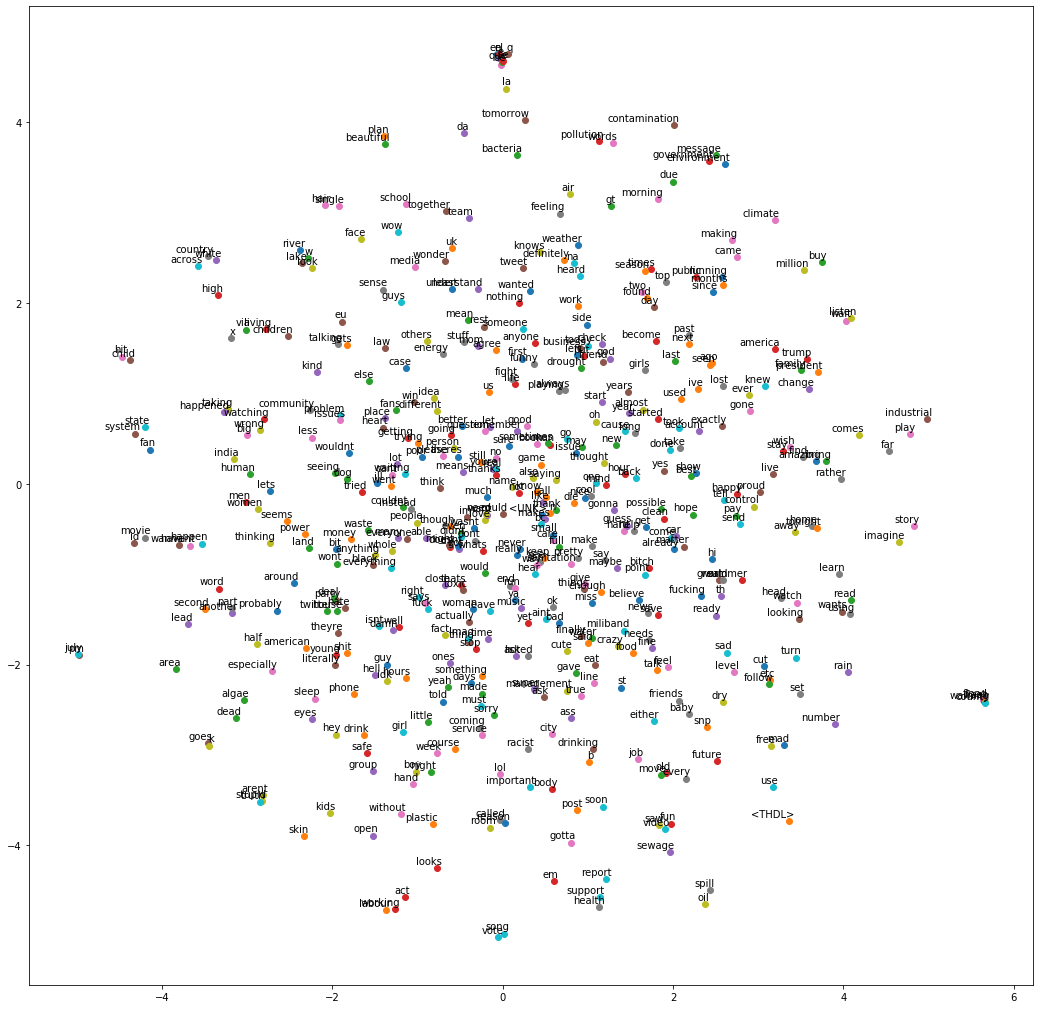

In [34]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

## Randomly Sampling the Gathered Tweets
Skip unless called?

In [31]:
def rnd_sample_csv(dataframe, size, keyword_type, num):
    
    '''dataframe needs to be a pandas dataframe,
    size is the number we are randomly sampling, should be an integer,
    keyword needs to be a string,
    num is the number of the file, should be an integer'''
    
    sampled_df = dataframe.sample(n = size, replace = False, random_state = 42)
    path = "datasets/water_tweets/sampled_tweets"
    file_name = "sampled_tweets_" + str(keyword_type) + '_' + str(num) + ".csv"
    sampled_df.to_csv(str(path) + '/' + str(file_name), sep = ';')

In [32]:
rnd_sample_csv(water_csvs, 2500, 'water', 1)
#rnd_sample_csv(all_csvs, 20000, 'all', 0)